In [1]:
# Import PyTorch and related packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Import packages for data manipulation and data splitting
import re
from fuzzywuzzy import process, fuzz

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

# Logging / metrics
# import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt

# Downloading datasets, and loading
from sklearn.datasets import fetch_openml

# Other
from collections import deque

In [2]:
# Ensure that floats are displayed with a decimal point
pd.options.display.float_format = '{:.1f}'.format

# Fetch the 'adult' dataset from OpenML
dataset = fetch_openml(name='SpeedDating', version=1)

# Create a Pandas DataFrame
df = pd.DataFrame(data=np.c_[dataset['data'], dataset['target']],
                  columns=dataset['feature_names'] + ['target'])

# Display the first few rows
print(df.head())

  has_null wave  gender  age age_o d_age d_d_age  \
0        0    1  female 21.0  27.0     6   [4-6]   
1        0    1  female 21.0  22.0     1   [0-1]   
2        1    1  female 21.0  22.0     1   [0-1]   
3        0    1  female 21.0  23.0     2   [2-3]   
4        0    1  female 21.0  24.0     3   [2-3]   

                                    race  \
0  Asian/Pacific Islander/Asian-American   
1  Asian/Pacific Islander/Asian-American   
2  Asian/Pacific Islander/Asian-American   
3  Asian/Pacific Islander/Asian-American   
4  Asian/Pacific Islander/Asian-American   

                                  race_o samerace  ... expected_num_matches  \
0            European/Caucasian-American        0  ...                  4.0   
1            European/Caucasian-American        0  ...                  4.0   
2  Asian/Pacific Islander/Asian-American        1  ...                  4.0   
3            European/Caucasian-American        0  ...                  4.0   
4               Latino/Hisp

In [3]:
def print_unique_for_column(df, column):
    unique_values = df[column].unique()
    sum = df[column].nunique(dropna=False)
    print(f"Unique values in column '{column}' with sum of {sum} (including NaN): {unique_values}")

def print_unique(df=df):
    # Loop through each column and print unique values
    for column in df.columns:
        print_unique_for_column(df, column)

print_unique(df)

Unique values in column 'has_null' with sum of 2 (including NaN): ['0' '1']
Unique values in column 'wave' with sum of 21 (including NaN): [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21]
Unique values in column 'gender' with sum of 2 (including NaN): ['female' 'male']
Unique values in column 'age' with sum of 25 (including NaN): [21.0 24.0 25.0 23.0 22.0 26.0 27.0 30.0 28.0 nan 29.0 34.0 35.0 32.0 39.0
 20.0 19.0 18.0 37.0 33.0 36.0 31.0 42.0 38.0 55.0]
Unique values in column 'age_o' with sum of 25 (including NaN): [27.0 22.0 23.0 24.0 25.0 30.0 28.0 21.0 26.0 29.0 nan 39.0 32.0 34.0 35.0
 18.0 20.0 19.0 37.0 33.0 36.0 31.0 42.0 38.0 55.0]
Unique values in column 'd_age' with sum of 35 (including NaN): [6 1 2 3 4 9 7 0 5 8 29 22 27 28 26 21 25 24 12 13 10 17 16 11 14 20 19 18
 32 37 15 34 23 30 36]
Unique values in column 'd_d_age' with sum of 4 (including NaN): ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
Unique values in column 'race' with sum of 6 (including NaN): ['Asian/Pacific Isl

## Data preprocessing

In [4]:
# Column field has a lot of problems
print(f"Sum: {df['field'].nunique(dropna=True)}")
sorted_unique_values = sorted(df['field'].dropna().unique())
for value in sorted_unique_values:
    print(value)

Sum: 259
Acting
African-American Studies/History
American Studies
American Studies [Masters]
Anthropology
Anthropology/Education
Applied Maths/Econs
Applied Physiology & Nutrition
Architecture
Art Education
Art History
Art History/medicine
Arts Administration
BUSINESS CONSULTING
Bilingual Education
Biochemistry
Biochemistry & Molecular Biophysics
Biology
Biology PhD
Biomedical Engineering
Biomedical Informatics
Biomedical engineering
Biotechnology
Business
Business & International Affairs
Business Administration
Business School
Business [Finance & Marketing]
Business [MBA]
Business and International Affairs [MBA/MIA Dual Degree]
Business- MBA
Business/ Finance/ Real Estate
Business/Law
Business; Media
Business; marketing
Cell Biology
Chemistry
Classics
Climate Dynamics
Climate-Earth and Environ. Science
Clinical Psychology
Cognitive Studies in Education
Communications
Communications in Education
Comparative Literature
Computational Biochemsistry
Computer Science
Conservation biology
Co

In [5]:
# Regular expression to match ;, :, -, /, and everything within []
pattern = r'[;:\-\/]|\[.*?\]'

# Replace matched patterns with an empty string
df['field'] = df['field'].str.replace(pattern, ' ', regex=True)

# Remove phd and remove duplicate space
df['field'] = df['field'].str.replace('phd', '', flags=re.IGNORECASE, regex=True).str.replace(' +', ' ', regex=True)

# Replace shortened engg. with engineering
df['field'] = df['field'].str.replace('engg.', 'engineering', flags=re.IGNORECASE, regex=True)

# Change everything to lowercase and remove white space
df['field'] = df['field'].str.lower().str.strip()
df['race'] = df['race'].str.lower().str.strip()
df['race_o'] = df['race_o'].str.lower().str.strip()

In [6]:
# Define a function to replace close matches
def combine_similar(df, column, correct_value, threshold=90):
    # Get unique values
    unique_values = df[column].unique()
    
    # Find matches above the threshold
    matches = process.extract(correct_value, unique_values, limit=None, scorer=fuzz.token_sort_ratio)
    close_matches = [match[0] for match in matches if match[1] >= threshold]
    
    # Replace close matches with the correct value
    df[column] = df[column].apply(lambda x: correct_value if x in close_matches else x)

combine_similar(df, 'field', 'finance')
combine_similar(df, 'field', 'nutrition')
combine_similar(df, 'field', 'speech language pathology')
combine_similar(df, 'field', 'international affairs')
combine_similar(df, 'field', 'finance economics')
combine_similar(df, 'field', 'mathematic')

In [7]:
# Dropped from 259 to 203 nut including NaN
print(f"Sum: {df['field'].nunique(dropna=True)}")
sorted_unique_values = sorted(df['field'].dropna().unique())
for value in sorted_unique_values:
    print(value)

Sum: 203
acting
african american studies history
american studies
anthropology
anthropology education
applied maths econs
applied physiology & nutrition
architecture
art education
art history
art history medicine
arts administration
bilingual education
biochemistry
biochemistry & molecular biophysics
biochemistry genetics
biology
biomedical engineering
biomedical informatics
biomedicine
biotechnology
business
business & international affairs
business administration
business and international affairs
business consulting
business finance real estate
business law
business marketing
business mba
business media
business school
cell biology
chemistry
classics
climate change
climate dynamics
climate earth and environ. science
clinical psychology
cognitive studies in education
communications
communications in education
comparative literature
computational biochemsistry
computer science
conservation biology
consulting
counseling psychology
creative writing
creative writing nonfiction
curriculum

In [8]:
def try_convert_float(value):
    try:
        return float(value)
    except ValueError:
        return value

for column in df.columns:
  df[column] = df[column].apply(try_convert_float)

print_unique(df)

Unique values in column 'has_null' with sum of 2 (including NaN): [0. 1.]
Unique values in column 'wave' with sum of 21 (including NaN): [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]
Unique values in column 'gender' with sum of 2 (including NaN): ['female' 'male']
Unique values in column 'age' with sum of 25 (including NaN): [21. 24. 25. 23. 22. 26. 27. 30. 28. nan 29. 34. 35. 32. 39. 20. 19. 18.
 37. 33. 36. 31. 42. 38. 55.]
Unique values in column 'age_o' with sum of 25 (including NaN): [27. 22. 23. 24. 25. 30. 28. 21. 26. 29. nan 39. 32. 34. 35. 18. 20. 19.
 37. 33. 36. 31. 42. 38. 55.]
Unique values in column 'd_age' with sum of 35 (including NaN): [ 6.  1.  2.  3.  4.  9.  7.  0.  5.  8. 29. 22. 27. 28. 26. 21. 25. 24.
 12. 13. 10. 17. 16. 11. 14. 20. 19. 18. 32. 37. 15. 34. 23. 30. 36.]
Unique values in column 'd_d_age' with sum of 4 (including NaN): ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
Unique values in column 'race' with sum of 6 (including

## Filling the NaN values

In [9]:
# Check how much of percentage is missing from every column
missing_values = (df.isnull().sum() / len(df)) * 100

for name, value in missing_values.items():
  print(f"{name}: {value:.2f}%")

has_null: 0.00%
wave: 0.00%
gender: 0.00%
age: 1.13%
age_o: 1.24%
d_age: 0.00%
d_d_age: 0.00%
race: 0.75%
race_o: 0.87%
samerace: 0.00%
importance_same_race: 0.94%
importance_same_religion: 0.94%
d_importance_same_race: 0.00%
d_importance_same_religion: 0.00%
field: 0.75%
pref_o_attractive: 1.06%
pref_o_sincere: 1.06%
pref_o_intelligence: 1.06%
pref_o_funny: 1.17%
pref_o_ambitious: 1.28%
pref_o_shared_interests: 1.54%
d_pref_o_attractive: 0.00%
d_pref_o_sincere: 0.00%
d_pref_o_intelligence: 0.00%
d_pref_o_funny: 0.00%
d_pref_o_ambitious: 0.00%
d_pref_o_shared_interests: 0.00%
attractive_o: 2.53%
sinsere_o: 3.43%
intelligence_o: 3.65%
funny_o: 4.30%
ambitous_o: 8.62%
shared_interests_o: 12.84%
d_attractive_o: 0.00%
d_sinsere_o: 0.00%
d_intelligence_o: 0.00%
d_funny_o: 0.00%
d_ambitous_o: 0.00%
d_shared_interests_o: 0.00%
attractive_important: 0.94%
sincere_important: 0.94%
intellicence_important: 0.94%
funny_important: 1.06%
ambtition_important: 1.18%
shared_interests_important: 1.44%
d

In [10]:
columns_to_drop = ['has_null', 'wave', 'expected_num_interested_in_me']
# columns_to_drop = ['has_null', 'wave', 'target']
df_features = df.drop(columns=columns_to_drop)

In [11]:
# This will select columns with data type 'object' or 'string'
string_columns = df_features.select_dtypes(include=['object', 'string'])

# Now, print these columns
print_unique(string_columns)

Unique values in column 'gender' with sum of 2 (including NaN): ['female' 'male']
Unique values in column 'd_d_age' with sum of 4 (including NaN): ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
Unique values in column 'race' with sum of 6 (including NaN): ['asian/pacific islander/asian-american' 'european/caucasian-american'
 'other' 'latino/hispanic american' 'black/african american' nan]
Unique values in column 'race_o' with sum of 6 (including NaN): ['european/caucasian-american' 'asian/pacific islander/asian-american'
 'latino/hispanic american' 'other' 'black/african american' nan]
Unique values in column 'd_importance_same_race' with sum of 3 (including NaN): ['[2-5]' '[6-10]' '[0-1]']
Unique values in column 'd_importance_same_religion' with sum of 3 (including NaN): ['[2-5]' '[0-1]' '[6-10]']
Unique values in column 'field' with sum of 204 (including NaN): ['law' 'economics' 'masters in public administration'
 'masters of social work&education' 'finance' 'business'
 'political science' 'mo

In [12]:
nominal_columns = ['gender', 'race', 'race_o', 'field']
ordinal_columns = string_columns.drop(columns=nominal_columns)

# Encode with one hot encoder
df_encoded = pd.get_dummies(df_features, columns=nominal_columns, drop_first=False)

# Encode with ordinal encoder

# Define the order of categories
order = {'[0-1]': 0.0, '[2-3]': 1.0, '[4-6]': 2.0, '[7-37]': 3.0,
         '[0-1]': 0.0, '[2-5]': 1.0, '[6-10]': 2.0,
         '[0-2]': 0.0, '[3-5]': 1.0, '[5-18]': 2.0,
         '[0-3]': 0.0, '[4-9]': 1.0, '[10-20]': 2.0,
         '[0-4]': 0.0, '[5-6]': 1.0, '[7-10]': 2.0,
         '[0-5]': 0.0, '[6-8]': 1.0, '[9-10]': 2.0, 
         '[0-15]': 0.0, '[16-20]': 1.0, '[21-100]': 2.0,
         '[-1-0]': 0.0, '[0-0.33]': 1.0, '[0.33-1]' : 2.0}

# Encode the data
for column in ordinal_columns:
    df_encoded[column] = df_encoded[column].map(order)

In [13]:
print_unique(df_encoded.select_dtypes(include=['object', 'string']))

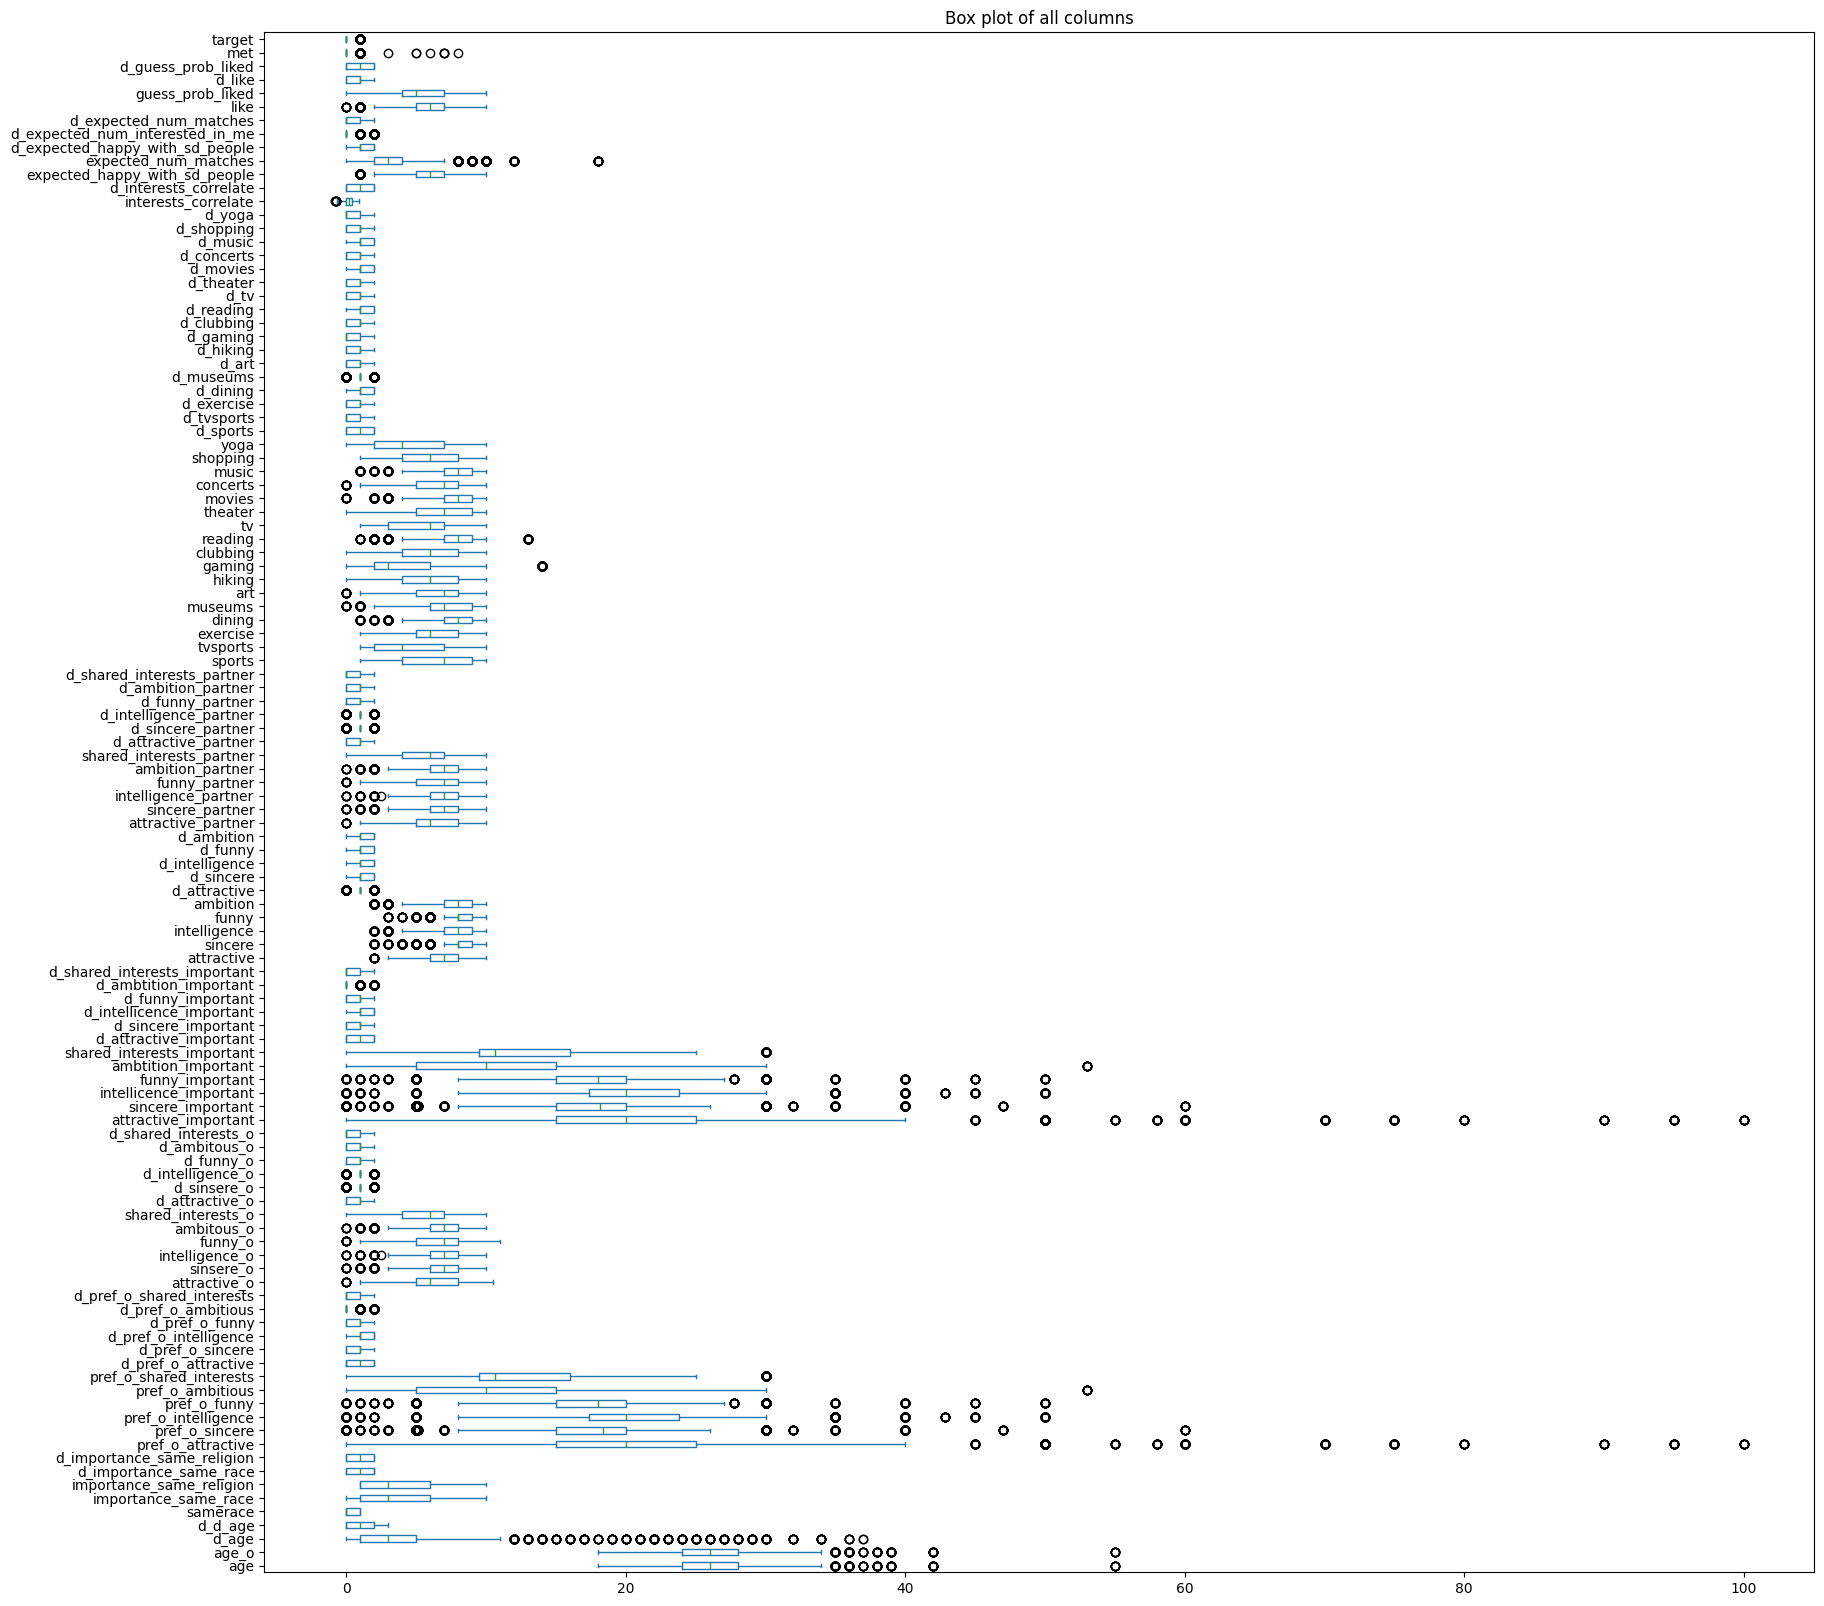

In [14]:
# Plotting box plots to check outliers
df_encoded.plot(kind='box', figsize=(20, 20), vert=False)
plt.title('Box plot of all columns')
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and then transform it
df_normalized = scaler.fit_transform(df_encoded)

# Convert the array back to a pandas DataFrame
df_normalized = pd.DataFrame(df_normalized, columns=df_encoded.columns)

In [16]:
# Initialize the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Fit the imputer to your data and transform it
imputed_data = imputer.fit_transform(df_normalized)

clean_data = pd.DataFrame(imputed_data, columns=df_encoded.columns)

Text(0.5, 1.0, 'Mutual Information Scores')

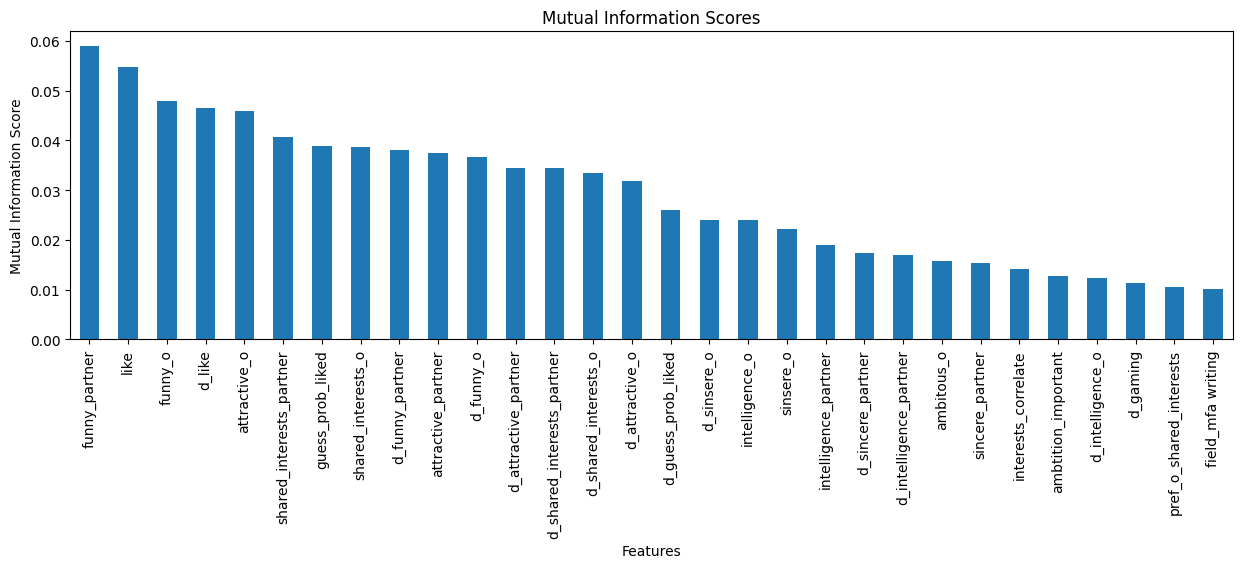

In [17]:
X = clean_data.drop('target', axis=1)
y = clean_data['target']

mic = mutual_info_classif(X, y)

mic_series = pd.Series(mic, index=X.columns)
mic_series = mic_series.sort_values(ascending=False)

mic_series = mic_series[mic_series > 0.01]

mic_series.plot.bar(figsize=(15, 4))
plt.ylabel('Mutual Information Score')
plt.xlabel('Features')
plt.title('Mutual Information Scores')

In [18]:
clean_data = clean_data[mic_series.index.tolist()]
target_data = df['target']
print(f"Data shape is: {clean_data.shape}")

print("Column names: ")
i = 1
for column, _value in clean_data.items():
  print(i, column)
  i+=1

Data shape is: (8378, 30)
Column names: 
1 funny_partner
2 like
3 funny_o
4 d_like
5 attractive_o
6 shared_interests_partner
7 guess_prob_liked
8 shared_interests_o
9 d_funny_partner
10 attractive_partner
11 d_funny_o
12 d_attractive_partner
13 d_shared_interests_partner
14 d_shared_interests_o
15 d_attractive_o
16 d_guess_prob_liked
17 d_sinsere_o
18 intelligence_o
19 sinsere_o
20 intelligence_partner
21 d_sincere_partner
22 d_intelligence_partner
23 ambitous_o
24 sincere_partner
25 interests_correlate
26 ambtition_important
27 d_intelligence_o
28 d_gaming
29 pref_o_shared_interests
30 field_mfa writing


# MLP

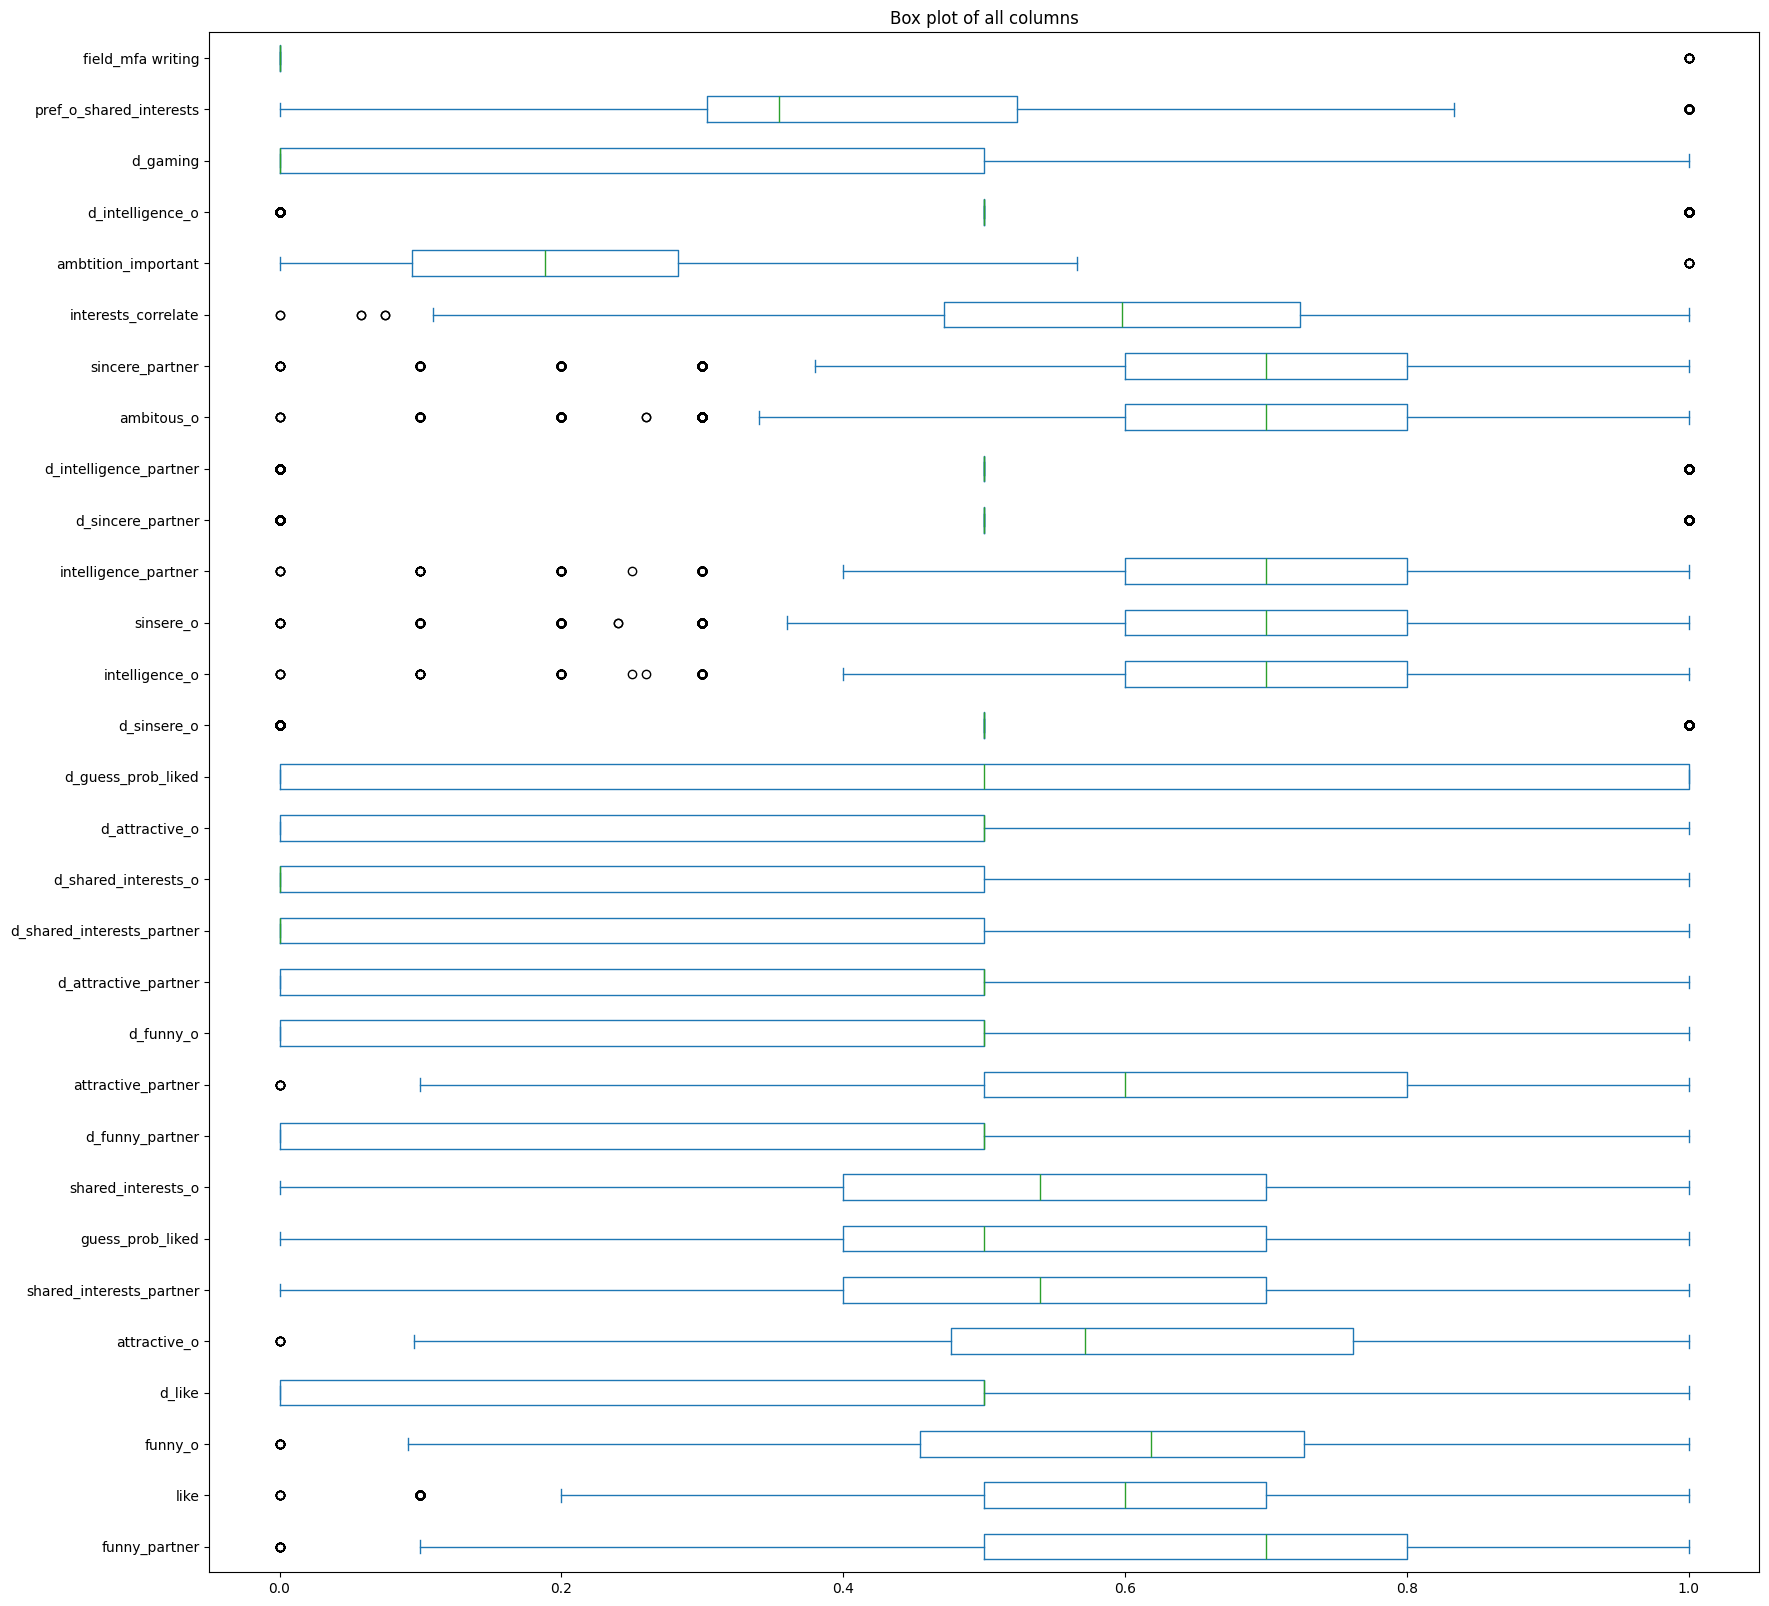

In [19]:
# Plotting box plots to check outliers
clean_data.plot(kind='box', figsize=(20, 20), vert=False)
plt.title('Box plot of all columns')
plt.show()

In [20]:
# Define the feature set X and the target variable y
X = clean_data
y = target_data

# Let's split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47, stratify=y)

# Verify the shape of each set
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (6702, 30), (6702,)
Test set: (1676, 30), (1676,)


In [21]:
# Convert Pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDataset for each set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Verify the DataLoader objects
for inputs, labels in train_loader:
    print(f"Batch shape: {inputs.shape}, Label shape: {labels.shape}")
    break

Batch shape: torch.Size([64, 30]), Label shape: torch.Size([64])


In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [23]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size: int = len(clean_data.columns), hidden_size: int = 256, dropout_ratio: float = 0.2):
        super(SimpleMLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.norm = nn.BatchNorm1d(hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.dropout_layer = nn.Dropout(dropout_ratio)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.leaky_relu(x)
        x = self.hidden_layer(x) + x
        x = self.norm(x)
        x = self.dropout_layer(x)
        x = F.leaky_relu(x)
        x = self.output_layer(x)
        
        return x

model = SimpleMLP().to(device)
optim = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = F.binary_cross_entropy_with_logits

In [24]:
train_losses = deque(maxlen=50)
epochs = 50

for i in range(epochs):
    epoch_train_loss = []

    with tqdm(total=len(train_loader), position=0, leave=True) as pbar:
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optim.zero_grad()
            out = model(x)
            loss = loss_fn(out, y.unsqueeze(-1))
            loss.backward()
            optim.step()
            train_losses.append(loss.item())
            epoch_train_loss.append(loss.item())
            pbar.set_postfix_str(f"Epoch: {i}, Avg. train loss: {sum(train_losses) / len(train_losses)}")
            pbar.update(1)

    print(f"Epoch Train Loss: {sum(epoch_train_loss) / len(epoch_train_loss)}")

    correct = 0
    total = 0
    with torch.inference_mode():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)  # Get model outputs (logits)
            probs = torch.sigmoid(out)  # Convert logits to probabilities
            preds = (probs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == y.unsqueeze(1)).sum().item()  # Adjust dimension of y if necessary
            total += y.size(0)

    avg_accuracy = correct / total
    print(f"Epoch Average Accuracy: {avg_accuracy}")

100%|██████████| 105/105 [00:00<00:00, 247.32it/s, Epoch: 0, Avg. train loss: 0.34814213871955874]


Epoch Train Loss: 0.36139307901972817
Epoch Average Accuracy: 0.8526252983293556


100%|██████████| 105/105 [00:00<00:00, 345.48it/s, Epoch: 1, Avg. train loss: 0.3271923819184303] 


Epoch Train Loss: 0.32986555780683247
Epoch Average Accuracy: 0.8532219570405728


100%|██████████| 105/105 [00:00<00:00, 338.71it/s, Epoch: 2, Avg. train loss: 0.32218062072992326]


Epoch Train Loss: 0.32247659720125654
Epoch Average Accuracy: 0.8556085918854416


100%|██████████| 105/105 [00:00<00:00, 332.28it/s, Epoch: 3, Avg. train loss: 0.32624339491128923]


Epoch Train Loss: 0.3180803765853246
Epoch Average Accuracy: 0.8532219570405728


100%|██████████| 105/105 [00:00<00:00, 347.68it/s, Epoch: 4, Avg. train loss: 0.3210451075434685] 


Epoch Train Loss: 0.3167530295394716
Epoch Average Accuracy: 0.869928400954654


100%|██████████| 105/105 [00:00<00:00, 351.17it/s, Epoch: 5, Avg. train loss: 0.30314885556697846]


Epoch Train Loss: 0.31223666199616024
Epoch Average Accuracy: 0.8591885441527446


100%|██████████| 105/105 [00:00<00:00, 345.39it/s, Epoch: 6, Avg. train loss: 0.30315848052501676]


Epoch Train Loss: 0.3079193379197802
Epoch Average Accuracy: 0.8585918854415274


100%|██████████| 105/105 [00:00<00:00, 354.59it/s, Epoch: 7, Avg. train loss: 0.3248390558362007] 


Epoch Train Loss: 0.30610022984799884
Epoch Average Accuracy: 0.8609785202863962


100%|██████████| 105/105 [00:00<00:00, 320.12it/s, Epoch: 8, Avg. train loss: 0.30063082635402677]


Epoch Train Loss: 0.3034589510588419
Epoch Average Accuracy: 0.863961813842482


100%|██████████| 105/105 [00:00<00:00, 347.68it/s, Epoch: 9, Avg. train loss: 0.2989654690027237] 


Epoch Train Loss: 0.2994234882649921
Epoch Average Accuracy: 0.85381861575179


100%|██████████| 105/105 [00:00<00:00, 344.26it/s, Epoch: 10, Avg. train loss: 0.3072489142417908]


Epoch Train Loss: 0.2978615729581742
Epoch Average Accuracy: 0.8621718377088305


100%|██████████| 105/105 [00:00<00:00, 350.00it/s, Epoch: 11, Avg. train loss: 0.3006091532111168] 


Epoch Train Loss: 0.2966756545362018
Epoch Average Accuracy: 0.8568019093078759


100%|██████████| 105/105 [00:00<00:00, 339.81it/s, Epoch: 12, Avg. train loss: 0.30619759440422056]


Epoch Train Loss: 0.2922429368609474
Epoch Average Accuracy: 0.8591885441527446


100%|██████████| 105/105 [00:00<00:00, 319.15it/s, Epoch: 13, Avg. train loss: 0.2912280756235123] 


Epoch Train Loss: 0.28786706981204807
Epoch Average Accuracy: 0.8579952267303103


100%|██████████| 105/105 [00:00<00:00, 350.82it/s, Epoch: 14, Avg. train loss: 0.28528376162052155]


Epoch Train Loss: 0.2864611905245554
Epoch Average Accuracy: 0.8573985680190931


100%|██████████| 105/105 [00:00<00:00, 339.81it/s, Epoch: 15, Avg. train loss: 0.2832940310239792] 


Epoch Train Loss: 0.28159839723791397
Epoch Average Accuracy: 0.8609785202863962


100%|██████████| 105/105 [00:00<00:00, 351.17it/s, Epoch: 16, Avg. train loss: 0.27308101803064344]


Epoch Train Loss: 0.2792052700406029
Epoch Average Accuracy: 0.863961813842482


100%|██████████| 105/105 [00:00<00:00, 345.39it/s, Epoch: 17, Avg. train loss: 0.2739065498113632] 


Epoch Train Loss: 0.2767032847518013
Epoch Average Accuracy: 0.8550119331742243


100%|██████████| 105/105 [00:00<00:00, 328.13it/s, Epoch: 18, Avg. train loss: 0.2727211725711822] 


Epoch Train Loss: 0.27214429804256984
Epoch Average Accuracy: 0.8568019093078759


100%|██████████| 105/105 [00:00<00:00, 343.14it/s, Epoch: 19, Avg. train loss: 0.2772535854578018] 


Epoch Train Loss: 0.27588350446451276
Epoch Average Accuracy: 0.8562052505966588


100%|██████████| 105/105 [00:00<00:00, 338.43it/s, Epoch: 20, Avg. train loss: 0.2784371560811996] 


Epoch Train Loss: 0.2689322959809076
Epoch Average Accuracy: 0.8514319809069213


100%|██████████| 105/105 [00:00<00:00, 287.15it/s, Epoch: 21, Avg. train loss: 0.27609633684158325]


Epoch Train Loss: 0.263342372292564
Epoch Average Accuracy: 0.8544152744630071


100%|██████████| 105/105 [00:00<00:00, 301.76it/s, Epoch: 22, Avg. train loss: 0.26525636404752734]


Epoch Train Loss: 0.26015388525667643
Epoch Average Accuracy: 0.8502386634844868


100%|██████████| 105/105 [00:00<00:00, 313.48it/s, Epoch: 23, Avg. train loss: 0.26839104235172273]


Epoch Train Loss: 0.26140792142777214
Epoch Average Accuracy: 0.8490453460620525


100%|██████████| 105/105 [00:00<00:00, 299.27it/s, Epoch: 24, Avg. train loss: 0.26245919555425645]


Epoch Train Loss: 0.25753647557326725
Epoch Average Accuracy: 0.8502386634844868


100%|██████████| 105/105 [00:00<00:00, 297.45it/s, Epoch: 25, Avg. train loss: 0.25698415875434877]


Epoch Train Loss: 0.24984517665136427
Epoch Average Accuracy: 0.8478520286396182


100%|██████████| 105/105 [00:00<00:00, 283.65it/s, Epoch: 26, Avg. train loss: 0.250000022649765]  


Epoch Train Loss: 0.2499656684341885
Epoch Average Accuracy: 0.847255369928401


100%|██████████| 105/105 [00:00<00:00, 303.47it/s, Epoch: 27, Avg. train loss: 0.25501034140586853]


Epoch Train Loss: 0.24866333504517873
Epoch Average Accuracy: 0.8514319809069213


100%|██████████| 105/105 [00:00<00:00, 303.53it/s, Epoch: 28, Avg. train loss: 0.23278583467006683]


Epoch Train Loss: 0.2408638135308311
Epoch Average Accuracy: 0.8448687350835322


100%|██████████| 105/105 [00:00<00:00, 303.47it/s, Epoch: 29, Avg. train loss: 0.24096968591213228]


Epoch Train Loss: 0.2389414893729346
Epoch Average Accuracy: 0.8424821002386634


100%|██████████| 105/105 [00:00<00:00, 287.67it/s, Epoch: 30, Avg. train loss: 0.25429089218378065]


Epoch Train Loss: 0.2368920876156716
Epoch Average Accuracy: 0.8389021479713604


100%|██████████| 105/105 [00:00<00:00, 301.72it/s, Epoch: 31, Avg. train loss: 0.2340454062819481] 


Epoch Train Loss: 0.22946854212454387
Epoch Average Accuracy: 0.8430787589498807


100%|██████████| 105/105 [00:00<00:00, 308.25it/s, Epoch: 32, Avg. train loss: 0.23682004302740098]


Epoch Train Loss: 0.23021232627687
Epoch Average Accuracy: 0.8353221957040573


100%|██████████| 105/105 [00:00<00:00, 298.29it/s, Epoch: 33, Avg. train loss: 0.21979867160320282]


Epoch Train Loss: 0.21948804230917068
Epoch Average Accuracy: 0.847255369928401


100%|██████████| 105/105 [00:00<00:00, 303.47it/s, Epoch: 34, Avg. train loss: 0.2268088087439537] 


Epoch Train Loss: 0.22525261754081363
Epoch Average Accuracy: 0.8400954653937948


100%|██████████| 105/105 [00:00<00:00, 287.68it/s, Epoch: 35, Avg. train loss: 0.2220626962184906] 


Epoch Train Loss: 0.21641490700699034
Epoch Average Accuracy: 0.8204057279236276


100%|██████████| 105/105 [00:00<00:00, 299.14it/s, Epoch: 36, Avg. train loss: 0.22234174713492394]


Epoch Train Loss: 0.21538302735203788
Epoch Average Accuracy: 0.8365155131264916


100%|██████████| 105/105 [00:00<00:00, 307.04it/s, Epoch: 37, Avg. train loss: 0.22516246616840363]


Epoch Train Loss: 0.21488652520236515
Epoch Average Accuracy: 0.8400954653937948


100%|██████████| 105/105 [00:00<00:00, 310.50it/s, Epoch: 38, Avg. train loss: 0.20760302424430846]


Epoch Train Loss: 0.20786755468164173
Epoch Average Accuracy: 0.8371121718377088


100%|██████████| 105/105 [00:00<00:00, 306.79it/s, Epoch: 39, Avg. train loss: 0.20990381494164467]


Epoch Train Loss: 0.20343134027151835
Epoch Average Accuracy: 0.8359188544152745


100%|██████████| 105/105 [00:00<00:00, 285.33it/s, Epoch: 40, Avg. train loss: 0.2093176707625389] 


Epoch Train Loss: 0.2028306021576836
Epoch Average Accuracy: 0.8287589498806682


100%|██████████| 105/105 [00:00<00:00, 307.02it/s, Epoch: 41, Avg. train loss: 0.20707805097103119]


Epoch Train Loss: 0.19524207810560862
Epoch Average Accuracy: 0.8317422434367542


100%|██████████| 105/105 [00:00<00:00, 308.82it/s, Epoch: 42, Avg. train loss: 0.19510768339037896]


Epoch Train Loss: 0.19572092656578335
Epoch Average Accuracy: 0.8412887828162291


100%|██████████| 105/105 [00:00<00:00, 302.59it/s, Epoch: 43, Avg. train loss: 0.18727044239640236]


Epoch Train Loss: 0.19023409294230598
Epoch Average Accuracy: 0.837708830548926


100%|██████████| 105/105 [00:00<00:00, 276.19it/s, Epoch: 44, Avg. train loss: 0.18429952815175057]


Epoch Train Loss: 0.1901518803976831
Epoch Average Accuracy: 0.8406921241050119


100%|██████████| 105/105 [00:00<00:00, 340.91it/s, Epoch: 45, Avg. train loss: 0.1836979153752327] 


Epoch Train Loss: 0.18320117649577913
Epoch Average Accuracy: 0.8257756563245824


100%|██████████| 105/105 [00:00<00:00, 342.02it/s, Epoch: 46, Avg. train loss: 0.18789873585104944]


Epoch Train Loss: 0.18438313362144287
Epoch Average Accuracy: 0.8257756563245824


100%|██████████| 105/105 [00:00<00:00, 350.00it/s, Epoch: 47, Avg. train loss: 0.1914060667157173] 


Epoch Train Loss: 0.18308960362559273
Epoch Average Accuracy: 0.8210023866348448


100%|██████████| 105/105 [00:00<00:00, 347.69it/s, Epoch: 48, Avg. train loss: 0.17677576288580896]


Epoch Train Loss: 0.17317108547403698
Epoch Average Accuracy: 0.8299522673031027


100%|██████████| 105/105 [00:00<00:00, 323.08it/s, Epoch: 49, Avg. train loss: 0.16652192711830138]

Epoch Train Loss: 0.16943747188363756
Epoch Average Accuracy: 0.8436754176610979
